In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import requests
from bs4 import BeautifulSoup
from sklearn import svm
import matplotlib.pyplot as plt

# Keep in mind - mass shootings does not include other gun related deaths. 
- mass shootings are defined has having at least four people shot (not including the shooter) either killed or injured
For 2022, in total:
- 44352 have died from gun violence
- 20262 from homicide/ murder/unintentional 
- suicide 
msas shootings 2022: 
- 3373 casualties in total for mass shootings
- 675 dead from mass shootings

- Datasets to use: 
    - https://ballotpedia.org/State_legislative_elections,_2022 house and senate majorities as of 2022
        labeled: chamberDf -> senateDf, houseDf
    - https://www.gunviolencearchive.org/reports/mass-shooting?year=2022 2022 mass shootings
        labeled: shootingsDf
    - https://www.kaggle.com/datasets/paultimothymooney/percent-voting-for-democratic-party-by-state?select=democratic_vs_republican_votes_by_usa_state_2020.csv 2020 presidential elections
        labeled: votingDf
    - https://www.census.gov/library/visualizations/interactive/racial-and-ethnic-diversity-in-the-united-states-2010-and-2020-census.html 2020 concensus
        labeled: raceDf
        
        
    - stateDf = raceDf and votingDf merged on state

# Data preprocessing and aggregation

In [2]:
votingDf = pd.read_csv('/kaggle/input/percent-voting-for-democratic-party-by-state/democratic_vs_republican_votes_by_usa_state_2020.csv')
votingDf = votingDf.drop(["usa_state", "usa_state_code"], axis=1)
votingDf['percent_republican'] = 100 - votingDf['percent_democrat'] 
votingDf.head(5)

,state,DEM,REP,percent_democrat,percent_republican
0,Alabama,843473,1434159,37.032892,62.967108
1,Alaska,45758,80999,36.098993,63.901007
2,Arizona,1643664,1626679,50.259682,49.740318
3,Arkansas,420985,761251,35.609218,64.390782
4,California,9315259,4812735,65.934760,34.065240


In [3]:
shootingsDf = pd.read_csv('/kaggle/input/gunviolencearchive2022/export-f85f25fd-88b3-470c-8c6a-8282d7aba586.csv')

In [4]:
city_col = shootingsDf['City Or County']
shootingsDf.drop(columns=['City Or County'], inplace=True)
shootingsDf.insert(0, 'City Or County', city_col)

state_col = shootingsDf['State']
shootingsDf.drop(columns=['State'], inplace=True)
shootingsDf.insert(0, 'State', state_col)
shootingsDf = shootingsDf.drop('Operations', axis=1)
shootingsDf

,State,City Or County,Incident ID,Incident Date,Address,# Killed,# Injured
0,Arizona,Phoenix,2491656,"December 31, 2022",4201 N 19th Ave,0,9
1,Alabama,Mobile,2492253,"December 31, 2022",200 block of Dauphin St,1,8
2,Tennessee,Memphis,2491054,"December 30, 2022",E Brooks Rd,1,3
3,Texas,Humble,2490925,"December 30, 2022",4800 block of Park Square Ln,2,3
4,New York,Bronx,2489614,"December 28, 2022",851 E Tremont Ave,1,3
...,...,...,...,...,...,...,...
641,Wisconsin,Kenosha,2201641,"January 1, 2022",1708 52nd St,1,3
642,Illinois,Peoria,2202001,"January 1, 2022",2000 block of SW Adams St,2,2
643,South Carolina,Dillon,2201876,"January 1, 2022",3261 Hwy 9,0,5
644,Indiana,South Bend,2201848,"January 1, 2022",1500 block of S Miami St,0,4


In [5]:
#add a casualities column to have both killed and injured as total
shootingsDf['Casualties']=shootingsDf['# Killed']+shootingsDf['# Injured']
shootingsDf.head

<bound method NDFrame.head of               State City Or County  Incident ID      Incident Date  \
0           Arizona        Phoenix      2491656  December 31, 2022   
1           Alabama         Mobile      2492253  December 31, 2022   
2         Tennessee        Memphis      2491054  December 30, 2022   
3             Texas         Humble      2490925  December 30, 2022   
4          New York          Bronx      2489614  December 28, 2022   
..              ...            ...          ...                ...   
641       Wisconsin        Kenosha      2201641    January 1, 2022   
642        Illinois         Peoria      2202001    January 1, 2022   
643  South Carolina         Dillon      2201876    January 1, 2022   
644         Indiana     South Bend      2201848    January 1, 2022   
645        Colorado         Denver      2201677    January 1, 2022   

                          Address  # Killed  # Injured  Casualties  
0                 4201 N 19th Ave         0          9      

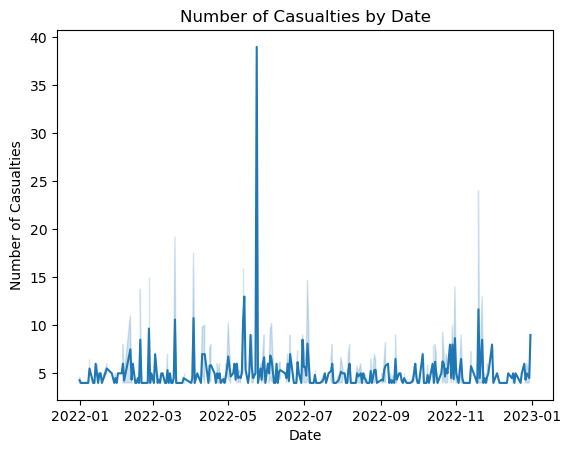

In [6]:
shootingsDf['Incident Date'] = pd.to_datetime(shootingsDf['Incident Date'])

# Create the line plot using seaborn
sns.lineplot(x='Incident Date', y='Casualties', data=shootingsDf)

# Set the plot title and axis labels
plt.title('Number of Casualties by Date')
plt.xlabel('Date')
plt.ylabel('Number of Casualties')

# Display the plot
plt.show()

# EDA of Senate and House Merged

In [7]:
url = 'https://ballotpedia.org/State_legislative_elections,_2022'
response = requests.get(url)
# parse the HTML content using Beautiful Soup
soup = BeautifulSoup(response.content, 'html.parser')

# find the tbody containing the data
table = soup.find_all('tbody')[5]
rows = table.find_all('tr')
data = []
for row in rows:
    cols = row.find_all('td')
    cols = [col.get_text().strip() for col in cols]
    #print(cols)
    data.append(cols)
del data[0:2]
chamberDf = pd.DataFrame(data, columns=['Chamber', 'Primary Date', 'Majority'])
chamberDf['Majority'] = chamberDf['Majority'].replace(['Power-sharing agreement'],'Split')

In [8]:
def get_state_name(chamber_name):
    state_name = chamber_name.split()[0]
    if state_name == 'New' or state_name == 'North' or state_name == 'South' or state_name == 'West':
        state_name += ' ' + chamber_name.split()[1]
    return state_name
chamberDf['State'] = chamberDf['Chamber'].apply(get_state_name)

In [9]:
chamberDf = chamberDf.reset_index(drop=True)
last_col = chamberDf.iloc[:, -1]  # select the last column
chamberDf = chamberDf.iloc[:, :-1]  # drop the last column
chamberDf.insert(0, 'State', last_col) #add it as the first hehe

In [10]:
chamberDf
chamberDf.loc[len(chamberDf)] = ['District of Columbia', 'DC House', '-', 'Democratic']
chamberDf.loc[len(chamberDf)] = ['District of Columbia', 'DC Senate', '-', 'Democratic']
chamberDf.loc[len(chamberDf)] = ['Virginia', 'Virginia State Senate', 'June 11', 'Democratic']
chamberDf.loc[len(chamberDf)] = ['Virginia', 'Virginia House of Delegates', 'June 11', 'Democratic']

In [11]:
#spliitng chambers df into senate and others
mask = chamberDf.Chamber.str.contains("Senate")
senateDf = chamberDf[mask]
houseDf = chamberDf[~mask]
senateDf.set_axis(['state', 'chamber', 'senPrimaryDate', 'senateMajority'], axis=1, inplace=False)
houseDf.set_axis(['state', 'chamber', 'housePrimaryDate', 'houseMajority'],axis=1, inplace=False)
senateDf.reset_index()
houseDf.reset_index()

,index,State,Chamber,Primary Date,Majority
0,0,Alabama,Alabama House of Representatives,May 24,Republican
1,2,Alaska,Alaska House of Representatives,August 16,Split
2,4,Arizona,Arizona House of Representatives,August 2,Republican
3,6,Arkansas,Arkansas House of Representatives,May 24,Republican
4,8,California,California State Assembly,June 7,Democratic
5,10,Colorado,Colorado House of Representatives,June 28,Democratic
6,12,Connecticut,Connecticut House of Representatives,August 9,Democratic
7,14,Delaware,Delaware House of Representatives,September 13,Democratic
8,16,Florida,Florida House of Representatives,August 23,Republican
9,18,Georgia,Georgia House of Representatives,May 24,Republican


In [12]:
states = ['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut', 'Delaware','District of Columbia',
          'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana',
          'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi', 'Missouri', 'Montana',
          'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico', 'New York', 'North Carolina',
          'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina',
          'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington', 'West Virginia',
          'Wisconsin', 'Wyoming']

df = pd.DataFrame(states, columns=['State'])

In [13]:
senateDf = pd.merge(senateDf, df, on='State', how='outer')
houseDf = pd.merge(houseDf, df, on='State', how='outer')
senateDf = senateDf.rename(columns={'Majority':'senateMajority'})
houseDf = houseDf.rename(columns={'Majority':'houseMajority'})

In [14]:
senateDf = senateDf.drop('Chamber', axis=1)
senateDf = senateDf.drop('Primary Date', axis=1)
houseDf = houseDf.drop('Chamber', axis=1)
houseDf = houseDf.drop('Primary Date', axis=1)

In [15]:
# manually fill in the bottom values
senateDf.loc[43:51, 'senateMajority'] = ['Democratic','Republican', 'Republican', 'Democratic', 'Democratic', 'Democratic', 'Democratic', 'Republican', 'Republican']


In [16]:
senateDf = senateDf.drop(senateDf[senateDf['State'] == 'Rhode'].index)


In [17]:
# manually fill in the bottom values
houseDf.loc[47:51, 'houseMajority'] = ['Republican', 'Republican', 'Democratic', 'Democratic', 'Democratic']

In [18]:
houseDf = houseDf.drop(houseDf[houseDf['State'] == 'Rhode'].index)

# Incidents by State

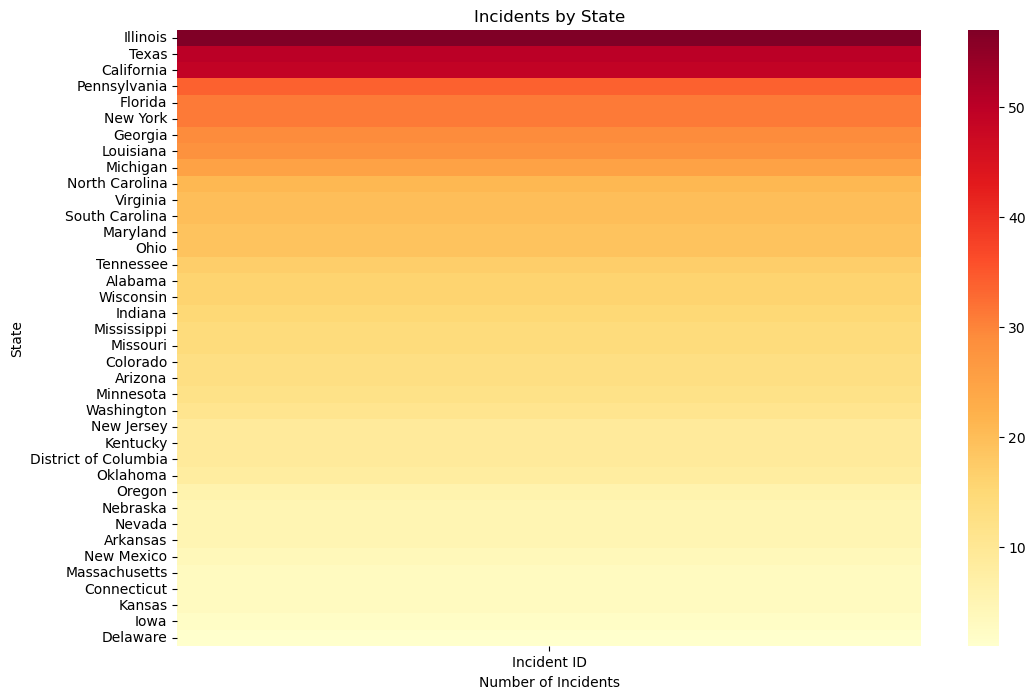

In [19]:
incidents_by_state = shootingsDf['State'].value_counts()
incidents_pivot = pd.pivot_table(shootingsDf, values='Incident ID', index='State', aggfunc=len)

# Sort the pivot table in descending order by the number of incidents
incidents_pivot = incidents_pivot.sort_values(by='Incident ID', ascending=False)

plt.figure(figsize=(12, 8))
sns.heatmap(incidents_pivot, cmap='YlOrRd')
plt.title('Incidents by State')
plt.xlabel('Number of Incidents')
plt.ylabel('State')
plt.show()


In [20]:
#group by
shootingsDf_gb = shootingsDf.groupby('State')
shootingsDf_gb['Casualties'].agg( ['count', 'min', 'max', 'mean', 'median', 'std', 'sum'] )

,count,min,max,mean,median,std,sum
State,,,,,,,
Alabama,16,4,9,5.000000,4.5,1.414214,80
Arizona,13,4,11,6.384615,6.0,2.433737,83
Arkansas,5,4,27,8.800000,4.0,10.183320,44
California,49,4,18,5.102041,4.0,2.210250,250
Colorado,13,4,24,6.307692,4.0,5.452593,82
Connecticut,3,4,4,4.000000,4.0,0.000000,12
Delaware,1,4,4,4.000000,4.0,NaN,4
District of Columbia,9,4,6,4.555556,4.0,0.726483,41
Florida,31,4,10,4.903226,5.0,1.300124,152


In [21]:
shootings_by_state = shootingsDf['State'].value_counts()
shootingsDf_percentage = (shootings_by_state / shootings_by_state.sum()) * 100

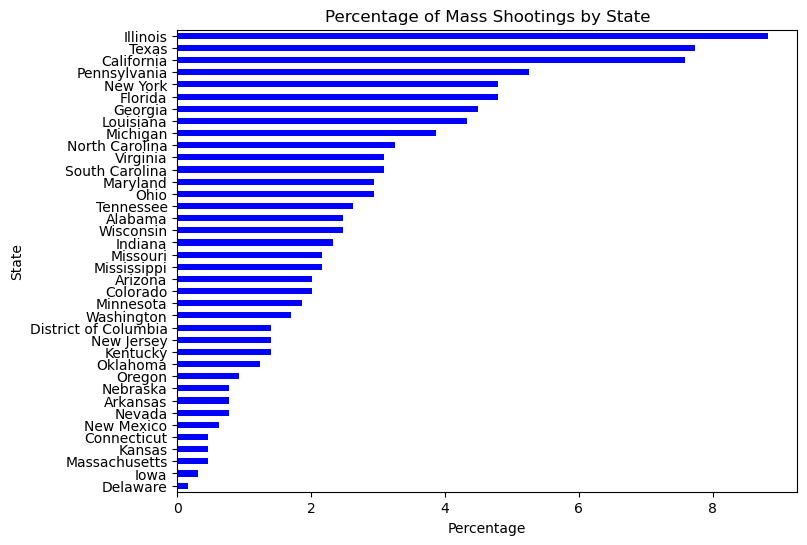

In [22]:
plt.figure(figsize=(8, 6))
shootingsDf_percentage.sort_values(ascending=True).plot(kind='barh', color='blue')
plt.title('Percentage of Mass Shootings by State')
plt.xlabel('Percentage')
plt.ylabel('State')
plt.show()

In [23]:
senateMerged = pd.merge(shootingsDf, senateDf, on = 'State',how='left')

In [24]:
houseMerged = pd.merge(shootingsDf, houseDf, on = 'State',how='left')

Now we have merged dataframes with the house and senate along side every instance of a mass shooting. 

In [25]:
senateMerged

,State,City Or County,Incident ID,Incident Date,Address,# Killed,# Injured,Casualties,senateMajority
0,Arizona,Phoenix,2491656,2022-12-31,4201 N 19th Ave,0,9,9,Republican
1,Alabama,Mobile,2492253,2022-12-31,200 block of Dauphin St,1,8,9,Republican
2,Tennessee,Memphis,2491054,2022-12-30,E Brooks Rd,1,3,4,Republican
3,Texas,Humble,2490925,2022-12-30,4800 block of Park Square Ln,2,3,5,Republican
4,New York,Bronx,2489614,2022-12-28,851 E Tremont Ave,1,3,4,Democratic
...,...,...,...,...,...,...,...,...,...
641,Wisconsin,Kenosha,2201641,2022-01-01,1708 52nd St,1,3,4,Republican
642,Illinois,Peoria,2202001,2022-01-01,2000 block of SW Adams St,2,2,4,Democratic
643,South Carolina,Dillon,2201876,2022-01-01,3261 Hwy 9,0,5,5,Republican
644,Indiana,South Bend,2201848,2022-01-01,1500 block of S Miami St,0,4,4,Republican


# Analysis of Senate Merged

In [26]:
senateMerged['State'].nunique()


38

In [27]:
senateMerged.isnull().sum()


State             0
City Or County    0
Incident ID       0
Incident Date     0
Address           7
# Killed          0
# Injured         0
Casualties        0
senateMajority    0
dtype: int64

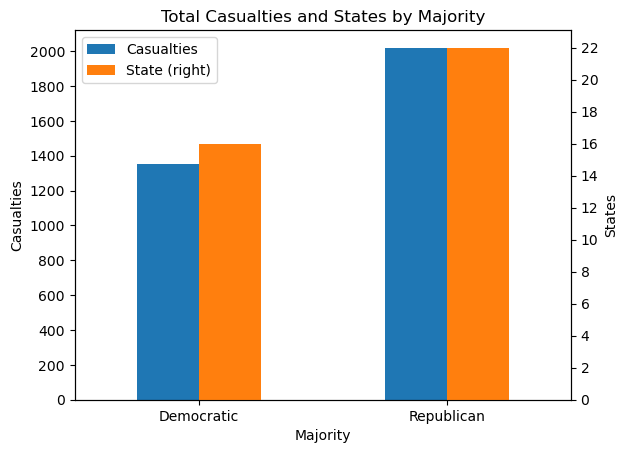

In [28]:

senate_gb = senateMerged.groupby('senateMajority')

# Get the sum of casualties for each state
Senate_State_Casualties = senate_gb['Casualties'].sum()

# Get the count of unique states for each party
unique_states = senate_gb['State'].nunique()

# Combine the two series into a single dataframe
df = pd.concat([Senate_State_Casualties, unique_states], axis=1)

# Create a bar plot with two y-axes
ax = df.plot(kind='bar', secondary_y='State', rot=0)

# Set the x-axis label
ax.set_xlabel('Majority')

# Set the y-axis label for casualties
ax.set_ylabel('Casualties')

# Set the y-axis label for unique states
ax.right_ax.set_ylabel('States')

# Set the title of the plot
ax.set_title('Total Casualties and States by Majority')

# Set the y-tick frequency for both axes
ax.set_yticks(np.arange(0, df['Casualties'].max()+1, 200))
ax.right_ax.set_yticks(np.arange(0, df['State'].max()+1, 2))

# Show the plot
plt.show()

In [29]:
senateMerged['senateMajority'].value_counts()

Republican    384
Democratic    262
Name: senateMajority, dtype: int64

# House merged Analysis

In [30]:
houseMerged_gb = houseMerged.groupby(['houseMajority', 'State'])

# calculate the number of casualties and unique states for each group
houseMerged_agg = houseMerged_gb.agg({'Casualties': 'sum'}) #

# Using Racial Demographics

In [31]:
raceDf = pd.read_excel('/kaggle/input/gunviolencearchive2022/DECENNIALPL2020.P1-2023-05-09T023306.xlsx',sheet_name=1)
raceDf = raceDf.drop([0, 1,2])
raceDf = raceDf.iloc[:,:10]
raceDf = raceDf.dropna().reset_index(inplace=False,drop=True)
raceDf = raceDf.drop(['Unnamed: 2'],axis=1)
raceDf = raceDf.drop([51])
raceDf = raceDf.set_axis(['State', 'totalPop', 'white', 'africanAmerican','native','asian','nativeHawaiianPacif','other','mixed'], axis=1, inplace=False)

race2 = raceDf.copy()  # Make a copy of the original DataFrame to avoid modifying it
race2['white'] = pd.to_numeric(raceDf['white'].str.replace(',', '')) / pd.to_numeric(raceDf['totalPop'].str.replace(',', ''))
race2['africanAmerican'] = pd.to_numeric(raceDf['africanAmerican'].str.replace(',', '')) / pd.to_numeric(raceDf['totalPop'].str.replace(',', ''))
race2['native'] = pd.to_numeric(raceDf['native'].str.replace(',', '')) / pd.to_numeric(raceDf['totalPop'].str.replace(',', ''))
race2['asian'] = pd.to_numeric(raceDf['asian'].str.replace(',', '')) / pd.to_numeric(raceDf['totalPop'].str.replace(',', ''))
race2['nativeHawaiianPacif'] = pd.to_numeric(raceDf['nativeHawaiianPacif'].str.replace(',', '')) / pd.to_numeric(raceDf['totalPop'].str.replace(',', ''))
race2['other'] = pd.to_numeric(raceDf['other'].str.replace(',', '')) / pd.to_numeric(raceDf['totalPop'].str.replace(',', ''))
race2['mixed'] = pd.to_numeric(raceDf['mixed'].str.replace(',', '')) / pd.to_numeric(raceDf['totalPop'].str.replace(',', ''))
raceDf = race2.copy()
raceDf['totalPop'] = pd.to_numeric(raceDf['totalPop'].str.replace(',', ''))
raceDf.head(5)

,State,totalPop,white,africanAmerican,native,asian,nativeHawaiianPacif,other,mixed
0,Alabama,5024279,0.640978,0.257980,0.006693,0.015258,0.000594,0.027356,0.051142
1,Alaska,733391,0.593670,0.029859,0.152136,0.060039,0.017314,0.024914,0.122069
2,Arizona,7151502,0.604396,0.047424,0.044678,0.035997,0.002293,0.125830,0.139384
3,Arkansas,3011524,0.702140,0.150682,0.009024,0.017214,0.004826,0.045195,0.070919
4,California,39538223,0.412161,0.056579,0.015960,0.153926,0.003977,0.211709,0.145688


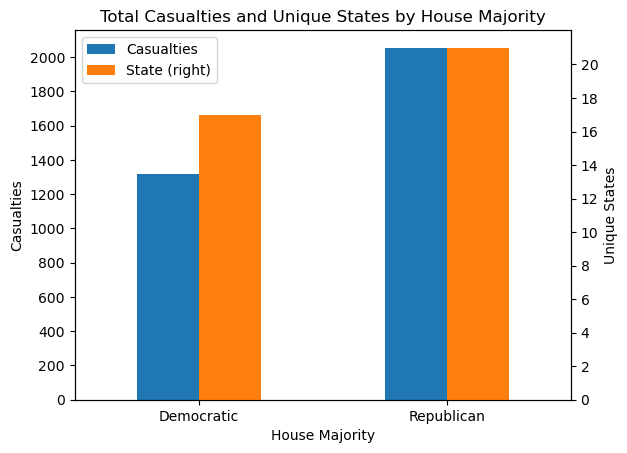

In [32]:
house_gb = houseMerged.groupby('houseMajority')

# Get the sum of casualties for each state
House_State_Casualties = house_gb['Casualties'].sum()

# Get the count of unique states for each party
unique_states = house_gb['State'].nunique()

# Combine the two series into a single dataframe
df = pd.concat([House_State_Casualties, unique_states], axis=1)

# Create a bar plot with two y-axes
ax = df.plot(kind='bar', secondary_y='State', rot=0)

# Set the x-axis label
ax.set_xlabel('House Majority')

# Set the y-axis label for casualties
ax.set_ylabel('Casualties')

# Set the y-axis label for unique states
ax.right_ax.set_ylabel('Unique States')

# Set the title of the plot
ax.set_title('Total Casualties and Unique States by House Majority')

# Set the y-tick frequency for both axes
ax.set_yticks(np.arange(0, df['Casualties'].max()+1, 200))
ax.right_ax.set_yticks(np.arange(0, df['State'].max()+1, 2))

# Show the plot
plt.show()

In [33]:
houseMerged['Casualties'].sum()

3373

# stateDf -> merge both raceDf and votingDf for whole state demographic

In [34]:
stateDf = pd.merge(raceDf, votingDf, left_on='State',right_on='state')
stateDf = stateDf.drop('state',axis=1)
stateDf.head(5)

,State,totalPop,white,africanAmerican,native,asian,nativeHawaiianPacif,other,mixed,DEM,REP,percent_democrat,percent_republican
0,Alabama,5024279,0.640978,0.257980,0.006693,0.015258,0.000594,0.027356,0.051142,843473,1434159,37.032892,62.967108
1,Alaska,733391,0.593670,0.029859,0.152136,0.060039,0.017314,0.024914,0.122069,45758,80999,36.098993,63.901007
2,Arizona,7151502,0.604396,0.047424,0.044678,0.035997,0.002293,0.125830,0.139384,1643664,1626679,50.259682,49.740318
3,Arkansas,3011524,0.702140,0.150682,0.009024,0.017214,0.004826,0.045195,0.070919,420985,761251,35.609218,64.390782
4,California,39538223,0.412161,0.056579,0.015960,0.153926,0.003977,0.211709,0.145688,9315259,4812735,65.934760,34.065240


# Shootings By Political Majority

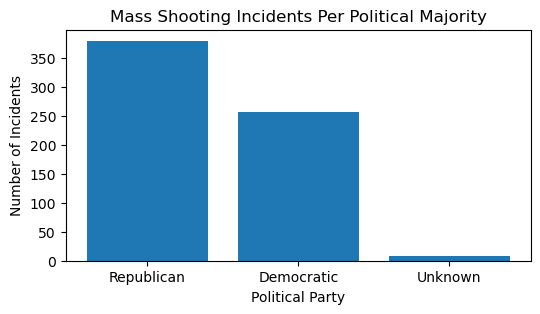

In [35]:
def get_party(state):
    return {"Alabama": "Republican", "Arizona": "Republican", "Arkansas": "Republican", "Florida": "Republican", "Georgia": "Republican", "Idaho": "Republican", "Indiana": "Republican", "Iowa": "Republican", "Kansas": "Republican", "Kentucky": "Republican", "Louisiana": "Republican", "Michigan": "Republican", "Missouri": "Republican", "Montana": "Republican", "Nebraska": "Republican", "New Hampshire": "Republican", "North Carolina": "Republican", "North Dakota": "Republican", "Ohio": "Republican", "Oklahoma": "Republican", "Pennsylvania": "Republican", "South Carolina": "Republican", "South Dakota": "Republican", "Tennessee": "Republican", "Texas": "Republican", "Utah": "Republican", "West Virginia": "Republican", "Wisconsin": "Republican", "California": "Democratic", "Colorado": "Democratic", "Connecticut": "Democratic", "Delaware": "Democratic", "Hawaii": "Democratic", "Illinois": "Democratic", "Maine": "Democratic", "Maryland": "Democratic", "Massachusetts": "Democratic", "Minnesota": "Democratic", "Mississippi": "Democratic", "Nevada": "Democratic", "New Jersey": "Democratic", "New Mexico": "Democratic", "New York": "Democratic", "Oregon": "Democratic", "Rhode Island": "Democratic", "Vermont": "Democratic", "Virginia": "Democratic", "Washington": "Democratic"}.get(state, "Unknown")
shootingsDf["Party"] = shootingsDf["State"].apply(get_party)


counts = shootingsDf["Party"].value_counts()
plt.figure(figsize=(6, 3))
plt.bar(counts.index, counts.values)
plt.title("Mass Shooting Incidents Per Political Majority")
plt.xlabel("Political Party")
plt.ylabel("Number of Incidents")
plt.show()

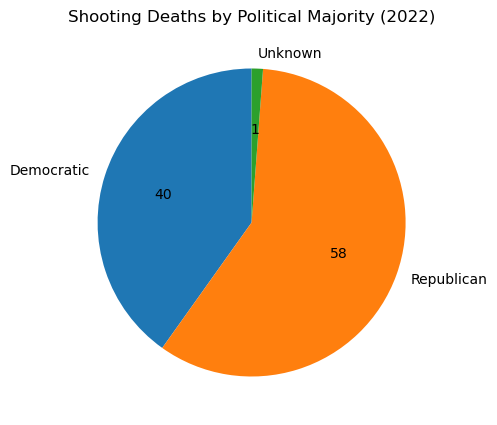

In [36]:
shootingsDf["Party"] = shootingsDf["State"].map(get_party)
deaths_by_party = shootingsDf.groupby("Party")["# Killed"].sum()
plt.figure(figsize=(5,5))
plt.pie(deaths_by_party.values, labels=deaths_by_party.index, autopct='%d', startangle=90)
plt.title("Shooting Deaths by Political Majority (2022)")
plt.show()

# Linear Regression:
- determine relationship between voting demographics as well as racial demographics and number of mass shootings as well as number of casualities potentially
- the idea is to first have a dataframe with counting the number of instances of mass shootings within the 
    - shootingsDf -> count isntances of states
    - plot and find correlation

In [37]:
shootingsDf.head(5)

,State,City Or County,Incident ID,Incident Date,Address,# Killed,# Injured,Casualties,Party
0,Arizona,Phoenix,2491656,2022-12-31,4201 N 19th Ave,0,9,9,Republican
1,Alabama,Mobile,2492253,2022-12-31,200 block of Dauphin St,1,8,9,Republican
2,Tennessee,Memphis,2491054,2022-12-30,E Brooks Rd,1,3,4,Republican
3,Texas,Humble,2490925,2022-12-30,4800 block of Park Square Ln,2,3,5,Republican
4,New York,Bronx,2489614,2022-12-28,851 E Tremont Ave,1,3,4,Democratic


In [38]:
counts = shootingsDf.groupby('State').count()
counts = counts.drop(['City Or County','Incident ID', 'Incident Date','Address','# Killed','# Injured'],axis=1)
counts = counts.rename(columns={'Casualties':'freq'})
casualtiesDf = shootingsDf.groupby('State')['Casualties'].sum()
linReg = pd.merge(counts, casualtiesDf, on='State')
linReg = pd.merge(linReg,stateDf, on='State')
linReg.head(5)

,State,freq,Party,Casualties,totalPop,white,africanAmerican,native,asian,nativeHawaiianPacif,other,mixed,DEM,REP,percent_democrat,percent_republican
0,Alabama,16,16,80,5024279,0.640978,0.257980,0.006693,0.015258,0.000594,0.027356,0.051142,843473,1434159,37.032892,62.967108
1,Arizona,13,13,83,7151502,0.604396,0.047424,0.044678,0.035997,0.002293,0.125830,0.139384,1643664,1626679,50.259682,49.740318
2,Arkansas,5,5,44,3011524,0.702140,0.150682,0.009024,0.017214,0.004826,0.045195,0.070919,420985,761251,35.609218,64.390782
3,California,49,49,250,39538223,0.412161,0.056579,0.015960,0.153926,0.003977,0.211709,0.145688,9315259,4812735,65.934760,34.065240
4,Colorado,13,13,82,5773714,0.707158,0.040672,0.012839,0.034610,0.001782,0.080372,0.122568,1753416,1335253,56.769307,43.230693


In [39]:
totalCasualties = linReg['Casualties'].sum()
totalShootings = linReg['freq'].sum()
linReg['percent_shootings'] = linReg['freq']/totalShootings
linReg['percent_casualties'] = linReg['Casualties']/totalCasualties
linReg['demRepRatio'] = linReg['DEM']/linReg['REP']
linReg.head(5)

,State,freq,Party,Casualties,totalPop,white,africanAmerican,native,asian,nativeHawaiianPacif,other,mixed,DEM,REP,percent_democrat,percent_republican,percent_shootings,percent_casualties,demRepRatio
0,Alabama,16,16,80,5024279,0.640978,0.257980,0.006693,0.015258,0.000594,0.027356,0.051142,843473,1434159,37.032892,62.967108,0.024768,0.023718,0.588131
1,Arizona,13,13,83,7151502,0.604396,0.047424,0.044678,0.035997,0.002293,0.125830,0.139384,1643664,1626679,50.259682,49.740318,0.020124,0.024607,1.010442
2,Arkansas,5,5,44,3011524,0.702140,0.150682,0.009024,0.017214,0.004826,0.045195,0.070919,420985,761251,35.609218,64.390782,0.007740,0.013045,0.553017
3,California,49,49,250,39538223,0.412161,0.056579,0.015960,0.153926,0.003977,0.211709,0.145688,9315259,4812735,65.934760,34.065240,0.075851,0.074118,1.935544
4,Colorado,13,13,82,5773714,0.707158,0.040672,0.012839,0.034610,0.001782,0.080372,0.122568,1753416,1335253,56.769307,43.230693,0.020124,0.024311,1.313171


In [40]:
corr_matrix = linReg.corr()
corr_matrix

,freq,Party,Casualties,totalPop,white,africanAmerican,native,asian,nativeHawaiianPacif,other,mixed,DEM,REP,percent_democrat,percent_republican,percent_shootings,percent_casualties,demRepRatio
freq,1.000000,1.000000,0.992352,0.798930,-0.354691,0.171271,-0.193032,0.308506,-0.172868,0.301079,0.150291,0.786845,0.808807,0.048088,-0.048088,1.000000,0.992352,-0.080027
Party,1.000000,1.000000,0.992352,0.798930,-0.354691,0.171271,-0.193032,0.308506,-0.172868,0.301079,0.150291,0.786845,0.808807,0.048088,-0.048088,1.000000,0.992352,-0.080027
Casualties,0.992352,0.992352,1.000000,0.787701,-0.348706,0.143695,-0.177823,0.287437,-0.135777,0.323890,0.185368,0.765811,0.801370,0.016650,-0.016650,0.992352,1.000000,-0.096982
totalPop,0.798930,0.798930,0.787701,1.000000,-0.369309,-0.118934,-0.125333,0.573135,0.018470,0.566013,0.395438,0.972142,0.904911,0.128631,-0.128631,0.798930,0.787701,-0.117215
white,-0.354691,-0.354691,-0.348706,-0.369309,1.000000,-0.510279,-0.194979,-0.488015,-0.096239,-0.633003,-0.480141,-0.339039,-0.184059,-0.496561,0.496561,-0.354691,-0.348706,-0.408963
africanAmerican,0.171271,0.171271,0.143695,-0.118934,-0.510279,1.000000,-0.336952,-0.152115,-0.339278,-0.302715,-0.406864,-0.154273,-0.093209,0.162520,-0.162520,0.171271,0.143695,0.431410
native,-0.193032,-0.193032,-0.177823,-0.125333,-0.194979,-0.336952,1.000000,-0.115375,0.152849,0.375585,0.600322,-0.146261,-0.180753,-0.093472,0.093472,-0.193032,-0.177823,-0.074806
asian,0.308506,0.308506,0.287437,0.573135,-0.488015,-0.152115,-0.115375,1.000000,0.380953,0.689117,0.335692,0.623359,0.278150,0.582647,-0.582647,0.308506,0.287437,0.130166
nativeHawaiianPacif,-0.172868,-0.172868,-0.135777,0.018470,-0.096239,-0.339278,0.152849,0.380953,1.000000,0.347819,0.346943,0.039784,-0.096728,0.045662,-0.045662,-0.172868,-0.135777,-0.052668
other,0.301079,0.301079,0.323890,0.566013,-0.633003,-0.302715,0.375585,0.689117,0.347819,1.000000,0.807374,0.554759,0.313385,0.384373,-0.384373,0.301079,0.323890,0.036649


Standardizing for regression

In [41]:
from sklearn.preprocessing import StandardScaler

# get the numerical columns in the DataFrame
numerical_cols = linReg.select_dtypes(include=[np.number]).columns

# create a new DataFrame with only the numerical columns
linReg_numerical = linReg[numerical_cols]

# create a new instance of the StandardScaler object
scaler = StandardScaler()

# standardize the numerical columns using the scaler
linReg_numerical_standardized = pd.DataFrame(scaler.fit_transform(linReg_numerical), columns=linReg_numerical.columns)

# combine the standardized numerical columns with the non-numerical columns in the original DataFrame
linReg_standardized = pd.concat([linReg[['State']], linReg_numerical_standardized], axis=1)
linReg_standardized.head(5)


,State,freq,Party,Casualties,totalPop,white,africanAmerican,native,asian,nativeHawaiianPacif,other,mixed,DEM,REP,percent_democrat,percent_republican,percent_shootings,percent_casualties,demRepRatio
0,Alabama,-0.073965,-0.073965,-0.122453,-0.421290,-0.055439,1.192430,-0.309724,-0.964533,-0.453081,-0.861397,-1.014364,-0.613598,-0.251216,-1.219340,1.219340,-0.073965,-0.122453,-0.335893
1,Arizona,-0.295859,-0.295859,-0.080532,-0.145825,-0.375766,-0.945221,1.584158,-0.277499,0.421784,1.436885,1.340741,-0.155962,-0.107922,-0.060576,0.060576,-0.295859,-0.080532,-0.180775
2,Arkansas,-0.887576,-0.887576,-0.625506,-0.681932,0.480120,0.103102,-0.193463,-0.899746,1.726181,-0.445053,-0.486532,-0.855222,-0.752066,-1.344064,1.344064,-0.887576,-0.625506,-0.348791
3,California,2.366870,2.366870,2.253070,4.048099,-2.059041,-0.852269,0.152322,3.629262,1.289336,3.441229,1.508979,4.231490,2.263479,1.312675,-1.312675,2.366870,2.253070,0.159024
4,Colorado,-0.295859,-0.295859,-0.094506,-0.324242,0.524056,-1.013767,-0.003266,-0.323442,0.158582,0.375955,0.891920,-0.093193,-0.324833,0.509715,-0.509715,-0.295859,-0.094506,-0.069579


In [42]:
from sklearn.linear_model import LinearRegression # regression algorithm
from sklearn.model_selection import train_test_split #for splitting
from sklearn.metrics import mean_absolute_error,r2_score,mean_squared_error
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

def run_experiment(model):
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    print("Training Set Evaluation:")
    print("R^2 : ", r2_score(y_train, y_train_pred))
    print("MAE :", mean_absolute_error(y_train, y_train_pred))
    print("RMSE:", np.sqrt(mean_squared_error(y_train, y_train_pred)))
    print("\nTesting Set Evaluation:")
    print("R^2 : ", r2_score(y_test, y_test_pred))
    print("MAE :", mean_absolute_error(y_test, y_test_pred))
    print("RMSE:", np.sqrt(mean_squared_error(y_test, y_test_pred)))


Training Set Evaluation:
R^2 :  0.6572859946154166
MAE : 0.4245008643141432
RMSE: 0.628112481558009

Testing Set Evaluation:
R^2 :  0.5833620814502135
MAE : 0.3711767325101219
RMSE: 0.46090536292776213


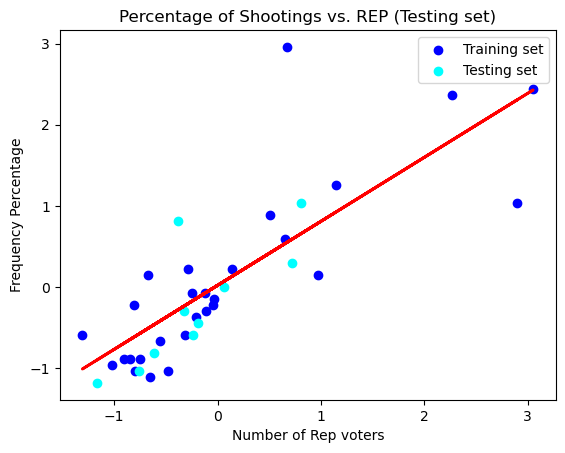

In [43]:
# Select the predictor variables and the target variable
X = linReg_standardized[['REP']]
y = linReg_standardized['percent_shootings']

# Split the data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Create a linear regression object and fit the model on the training data
reg = LinearRegression()
reg.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = reg.predict(X_test)

run_experiment(reg)
# Plot the training and testing set
plt.scatter(X_train['REP'], y_train, color='blue', label='Training set')
plt.plot(X_train['REP'], reg.predict(X_train), color='red', linewidth=2)
plt.scatter(X_test['REP'], y_test, color='cyan', label='Testing set')
plt.plot(X_test['REP'], reg.predict(X_test), color='red', linewidth=2)
plt.title('Percentage of Shootings vs. REP (Testing set)')
plt.xlabel('Number of Rep voters')
plt.ylabel('Frequency Percentage')
plt.legend(loc='best')
plt.show()

Training Set Evaluation:
R^2 :  0.6583040129848934
MAE : 0.44546707500880606
RMSE: 0.6271788961321952

Testing Set Evaluation:
R^2 :  0.3098563292638895
MAE : 0.501131858027889
RMSE: 0.5932013349813373


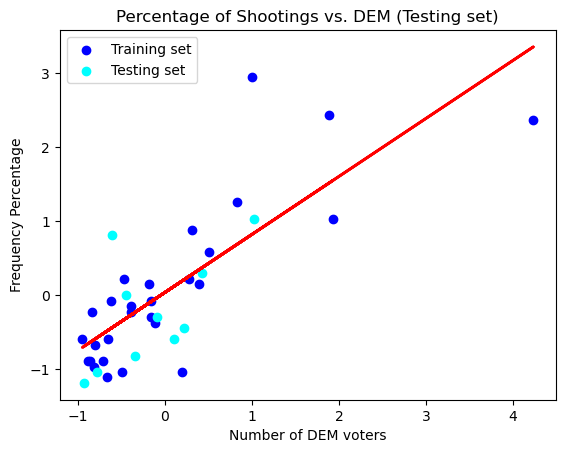

In [44]:
# Select the predictor variables and the target variable
X = linReg_standardized[['DEM']]
y = linReg_standardized['percent_shootings']

# Split the data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Create a linear regression object and fit the model on the training data
reg = LinearRegression()
reg.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = reg.predict(X_test)

run_experiment(reg)
# Plot the training and testing set
plt.scatter(X_train['DEM'], y_train, color='blue', label='Training set')
plt.plot(X_train['DEM'], reg.predict(X_train), color='red', linewidth=2)
plt.scatter(X_test['DEM'], y_test, color='cyan', label='Testing set')
plt.plot(X_test['DEM'], reg.predict(X_test), color='red', linewidth=2)
plt.title('Percentage of Shootings vs. DEM (Testing set)')
plt.xlabel('Number of DEM voters')
plt.ylabel('Frequency Percentage')
plt.legend(loc='best')
plt.show()

Training Set Evaluation:
R^2 :  0.6518118656828691
MAE : 0.008716630847054986
RMSE: 0.013464344526123915

Testing Set Evaluation:
R^2 :  0.5195374573610914
MAE : 0.008370088612035476
RMSE: 0.010279886533991044


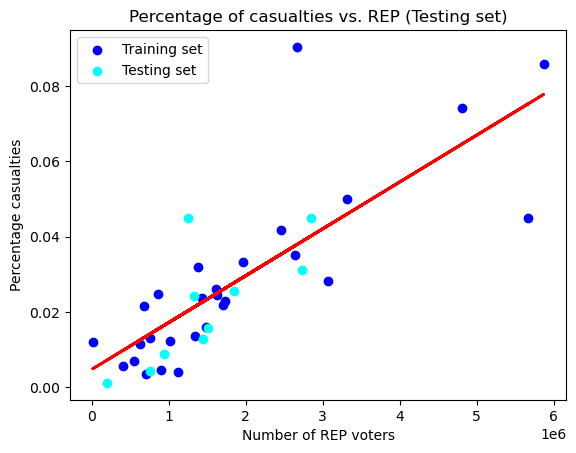

In [45]:
# Select the predictor variables and the target variable
X = linReg[['REP']]
y = linReg['percent_casualties']

# Split the data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Create a linear regression object and fit the model on the training data
reg = LinearRegression()
reg.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = reg.predict(X_test)

run_experiment(reg)
# Plot the training and testing set
plt.scatter(X_train['REP'], y_train, color='blue', label='Training set')
plt.plot(X_train['REP'], reg.predict(X_train), color='red', linewidth=2)
plt.scatter(X_test['REP'], y_test, color='cyan', label='Testing set')
plt.plot(X_test['REP'], reg.predict(X_test), color='red', linewidth=2)
plt.title('Percentage of casualties vs. REP (Testing set)')
plt.xlabel('Number of REP voters')
plt.ylabel('Percentage casualties')
plt.legend(loc='best')
plt.show()

Training Set Evaluation:
R^2 :  0.6284227181427346
MAE : 0.009111900743716258
RMSE: 0.013909221048878975

Testing Set Evaluation:
R^2 :  0.23192143433262224
MAE : 0.010406430395650475
RMSE: 0.012997546393602481


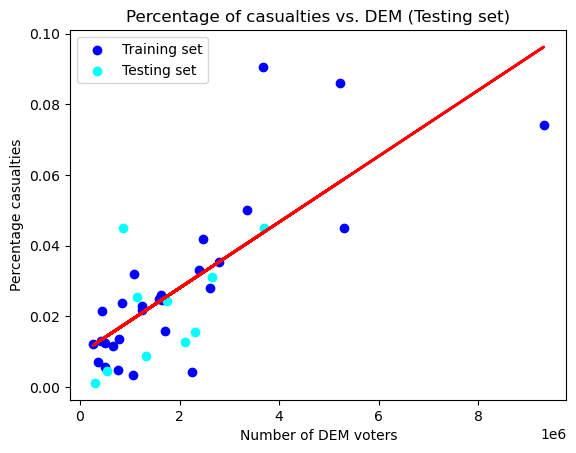

In [46]:
# Select the predictor variables and the target variable
X = linReg[['DEM']]
y = linReg['percent_casualties']

# Split the data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Create a linear regression object and fit the model on the training data
reg = LinearRegression()
reg.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = reg.predict(X_test)

run_experiment(reg)
# Plot the training and testing set
plt.scatter(X_train['DEM'], y_train, color='blue', label='Training set')
plt.plot(X_train['DEM'], reg.predict(X_train), color='red', linewidth=2)
plt.scatter(X_test['DEM'], y_test, color='cyan', label='Testing set')
plt.plot(X_test['DEM'], reg.predict(X_test), color='red', linewidth=2)
plt.title('Percentage of casualties vs. DEM (Testing set)')
plt.xlabel('Number of DEM voters')
plt.ylabel('Percentage casualties')
plt.legend(loc='best')
plt.show()

# Implementing Random Forest

In [47]:
# Fitting Random Forest Regression to the dataset
# import the regressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [48]:
data = senateMerged
data

,State,City Or County,Incident ID,Incident Date,Address,# Killed,# Injured,Casualties,senateMajority
0,Arizona,Phoenix,2491656,2022-12-31,4201 N 19th Ave,0,9,9,Republican
1,Alabama,Mobile,2492253,2022-12-31,200 block of Dauphin St,1,8,9,Republican
2,Tennessee,Memphis,2491054,2022-12-30,E Brooks Rd,1,3,4,Republican
3,Texas,Humble,2490925,2022-12-30,4800 block of Park Square Ln,2,3,5,Republican
4,New York,Bronx,2489614,2022-12-28,851 E Tremont Ave,1,3,4,Democratic
...,...,...,...,...,...,...,...,...,...
641,Wisconsin,Kenosha,2201641,2022-01-01,1708 52nd St,1,3,4,Republican
642,Illinois,Peoria,2202001,2022-01-01,2000 block of SW Adams St,2,2,4,Democratic
643,South Carolina,Dillon,2201876,2022-01-01,3261 Hwy 9,0,5,5,Republican
644,Indiana,South Bend,2201848,2022-01-01,1500 block of S Miami St,0,4,4,Republican


In [49]:
data = data.merge(linReg, left_on='State', right_on='State')
data

,State,City Or County,Incident ID,Incident Date,Address,# Killed,# Injured,Casualties_x,senateMajority,freq,...,nativeHawaiianPacif,other,mixed,DEM,REP,percent_democrat,percent_republican,percent_shootings,percent_casualties,demRepRatio
0,Arizona,Phoenix,2491656,2022-12-31,4201 N 19th Ave,0,9,9,Republican,13,...,0.002293,0.125830,0.139384,1643664,1626679,50.259682,49.740318,0.020124,0.024607,1.010442
1,Arizona,Phoenix,2478061,2022-12-09,S 21st and W Burgess LN,1,3,4,Republican,13,...,0.002293,0.125830,0.139384,1643664,1626679,50.259682,49.740318,0.020124,0.024607,1.010442
2,Arizona,Phoenix,2443231,2022-10-22,6330 W Miami St,1,7,8,Republican,13,...,0.002293,0.125830,0.139384,1643664,1626679,50.259682,49.740318,0.020124,0.024607,1.010442
3,Arizona,Phoenix,2400492,2022-08-28,21636 N 26th Ave,3,5,8,Republican,13,...,0.002293,0.125830,0.139384,1643664,1626679,50.259682,49.740318,0.020124,0.024607,1.010442
4,Arizona,Phoenix,2386954,2022-08-14,4601 E Granada Rd,1,4,5,Republican,13,...,0.002293,0.125830,0.139384,1643664,1626679,50.259682,49.740318,0.020124,0.024607,1.010442
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
641,Connecticut,Hartford,2375097,2022-07-31,1994 Main St,0,4,4,Democratic,3,...,0.000443,0.082956,0.092321,1059252,699079,60.241900,39.758100,0.004644,0.003558,1.515211
642,Connecticut,Hartford,2270578,2022-04-04,Bedford St and Mather St,1,3,4,Democratic,3,...,0.000443,0.082956,0.092321,1059252,699079,60.241900,39.758100,0.004644,0.003558,1.515211
643,Connecticut,Waterbury,2259262,2022-03-21,23 Scovill St,0,4,4,Democratic,3,...,0.000443,0.082956,0.092321,1059252,699079,60.241900,39.758100,0.004644,0.003558,1.515211
644,Iowa,Cedar Rapids,2274790,2022-04-10,415 3rd St SE,3,9,12,Republican,2,...,0.001805,0.027809,0.056195,757700,896102,45.815642,54.184358,0.003096,0.004744,0.845551


In [50]:
senMaj = data.pop('senateMajority')
data.insert(len(data.columns), 'senateMajority', senMaj)
data

,State,City Or County,Incident ID,Incident Date,Address,# Killed,# Injured,Casualties_x,freq,Party,...,other,mixed,DEM,REP,percent_democrat,percent_republican,percent_shootings,percent_casualties,demRepRatio,senateMajority
0,Arizona,Phoenix,2491656,2022-12-31,4201 N 19th Ave,0,9,9,13,13,...,0.125830,0.139384,1643664,1626679,50.259682,49.740318,0.020124,0.024607,1.010442,Republican
1,Arizona,Phoenix,2478061,2022-12-09,S 21st and W Burgess LN,1,3,4,13,13,...,0.125830,0.139384,1643664,1626679,50.259682,49.740318,0.020124,0.024607,1.010442,Republican
2,Arizona,Phoenix,2443231,2022-10-22,6330 W Miami St,1,7,8,13,13,...,0.125830,0.139384,1643664,1626679,50.259682,49.740318,0.020124,0.024607,1.010442,Republican
3,Arizona,Phoenix,2400492,2022-08-28,21636 N 26th Ave,3,5,8,13,13,...,0.125830,0.139384,1643664,1626679,50.259682,49.740318,0.020124,0.024607,1.010442,Republican
4,Arizona,Phoenix,2386954,2022-08-14,4601 E Granada Rd,1,4,5,13,13,...,0.125830,0.139384,1643664,1626679,50.259682,49.740318,0.020124,0.024607,1.010442,Republican
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
641,Connecticut,Hartford,2375097,2022-07-31,1994 Main St,0,4,4,3,3,...,0.082956,0.092321,1059252,699079,60.241900,39.758100,0.004644,0.003558,1.515211,Democratic
642,Connecticut,Hartford,2270578,2022-04-04,Bedford St and Mather St,1,3,4,3,3,...,0.082956,0.092321,1059252,699079,60.241900,39.758100,0.004644,0.003558,1.515211,Democratic
643,Connecticut,Waterbury,2259262,2022-03-21,23 Scovill St,0,4,4,3,3,...,0.082956,0.092321,1059252,699079,60.241900,39.758100,0.004644,0.003558,1.515211,Democratic
644,Iowa,Cedar Rapids,2274790,2022-04-10,415 3rd St SE,3,9,12,2,2,...,0.027809,0.056195,757700,896102,45.815642,54.184358,0.003096,0.004744,0.845551,Republican


In [51]:
senateMerged

,State,City Or County,Incident ID,Incident Date,Address,# Killed,# Injured,Casualties,senateMajority
0,Arizona,Phoenix,2491656,2022-12-31,4201 N 19th Ave,0,9,9,Republican
1,Alabama,Mobile,2492253,2022-12-31,200 block of Dauphin St,1,8,9,Republican
2,Tennessee,Memphis,2491054,2022-12-30,E Brooks Rd,1,3,4,Republican
3,Texas,Humble,2490925,2022-12-30,4800 block of Park Square Ln,2,3,5,Republican
4,New York,Bronx,2489614,2022-12-28,851 E Tremont Ave,1,3,4,Democratic
...,...,...,...,...,...,...,...,...,...
641,Wisconsin,Kenosha,2201641,2022-01-01,1708 52nd St,1,3,4,Republican
642,Illinois,Peoria,2202001,2022-01-01,2000 block of SW Adams St,2,2,4,Democratic
643,South Carolina,Dillon,2201876,2022-01-01,3261 Hwy 9,0,5,5,Republican
644,Indiana,South Bend,2201848,2022-01-01,1500 block of S Miami St,0,4,4,Republican


In [52]:
linReg.head(1)

,State,freq,Party,Casualties,totalPop,white,africanAmerican,native,asian,nativeHawaiianPacif,other,mixed,DEM,REP,percent_democrat,percent_republican,percent_shootings,percent_casualties,demRepRatio
0,Alabama,16,16,80,5024279,0.640978,0.25798,0.006693,0.015258,0.000594,0.027356,0.051142,843473,1434159,37.032892,62.967108,0.024768,0.023718,0.588131


In [53]:
data = data.drop(['DEM','REP','percent_republican','percent_democrat','demRepRatio'],axis=1)

In [54]:
data

,State,City Or County,Incident ID,Incident Date,Address,# Killed,# Injured,Casualties_x,freq,Party,...,white,africanAmerican,native,asian,nativeHawaiianPacif,other,mixed,percent_shootings,percent_casualties,senateMajority
0,Arizona,Phoenix,2491656,2022-12-31,4201 N 19th Ave,0,9,9,13,13,...,0.604396,0.047424,0.044678,0.035997,0.002293,0.125830,0.139384,0.020124,0.024607,Republican
1,Arizona,Phoenix,2478061,2022-12-09,S 21st and W Burgess LN,1,3,4,13,13,...,0.604396,0.047424,0.044678,0.035997,0.002293,0.125830,0.139384,0.020124,0.024607,Republican
2,Arizona,Phoenix,2443231,2022-10-22,6330 W Miami St,1,7,8,13,13,...,0.604396,0.047424,0.044678,0.035997,0.002293,0.125830,0.139384,0.020124,0.024607,Republican
3,Arizona,Phoenix,2400492,2022-08-28,21636 N 26th Ave,3,5,8,13,13,...,0.604396,0.047424,0.044678,0.035997,0.002293,0.125830,0.139384,0.020124,0.024607,Republican
4,Arizona,Phoenix,2386954,2022-08-14,4601 E Granada Rd,1,4,5,13,13,...,0.604396,0.047424,0.044678,0.035997,0.002293,0.125830,0.139384,0.020124,0.024607,Republican
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
641,Connecticut,Hartford,2375097,2022-07-31,1994 Main St,0,4,4,3,3,...,0.664217,0.107787,0.004451,0.047825,0.000443,0.082956,0.092321,0.004644,0.003558,Democratic
642,Connecticut,Hartford,2270578,2022-04-04,Bedford St and Mather St,1,3,4,3,3,...,0.664217,0.107787,0.004451,0.047825,0.000443,0.082956,0.092321,0.004644,0.003558,Democratic
643,Connecticut,Waterbury,2259262,2022-03-21,23 Scovill St,0,4,4,3,3,...,0.664217,0.107787,0.004451,0.047825,0.000443,0.082956,0.092321,0.004644,0.003558,Democratic
644,Iowa,Cedar Rapids,2274790,2022-04-10,415 3rd St SE,3,9,12,2,2,...,0.844580,0.041366,0.004541,0.023705,0.001805,0.027809,0.056195,0.003096,0.004744,Republican


In [55]:
# split the dataset
X = data.iloc[:, 7:21]
y = data.iloc[:, 21]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
# create the model
model = RandomForestClassifier(n_estimators=100, random_state=0)
# train the model
model.fit(X_train, y_train)
# predict the result
y_pred = model.predict(X_test)
# calculate the accuracy
print(' Testing Accuracy: ', accuracy_score(y_test, y_pred))

 Testing Accuracy:  1.0


training matrix

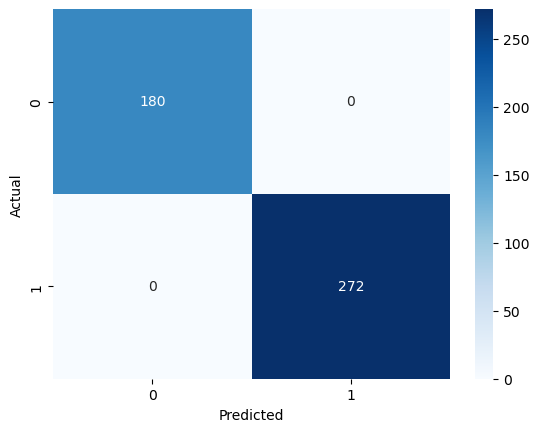

In [56]:
# predict on the training set
y_pred_train = model.predict(X_train)

# calculate accuracy on the training set
acc_train = accuracy_score(y_train, y_pred_train)

# create confusion matrix for training set
cm_train = confusion_matrix(y_train, y_pred_train)

# plot confusion matrix for training set
sns.heatmap(cm_train, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


testing matrix

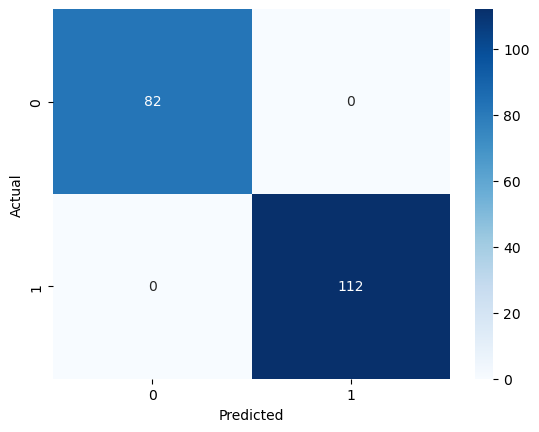

In [57]:
# create confusion matrix
cm = confusion_matrix(y_test, y_pred)

# plot confusion matrix
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Suspicious the model is just memorizing demographics so let's fix training overfitting with cross validation

In [58]:
from sklearn.model_selection import cross_val_score

# create the model
model = RandomForestClassifier(n_estimators=100, random_state=0)

# perform 5-fold cross-validation and get the accuracy scores
scores = cross_val_score(model, X, y, cv=5)

# print the average accuracy and standard deviation
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))


Accuracy: 0.87 (+/- 0.15)


[[239  23]
 [ 62 322]]


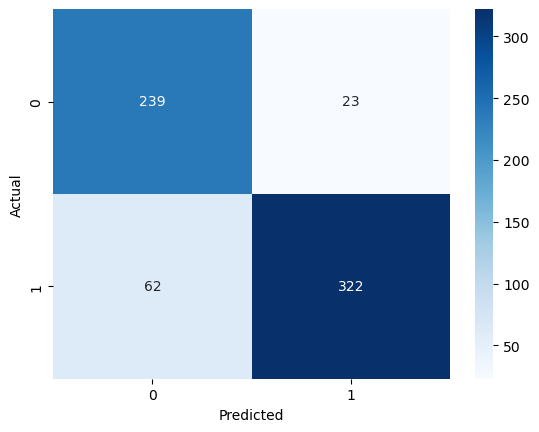

In [59]:
from sklearn.model_selection import cross_val_predict


# Perform cross-validation
y_pred = cross_val_predict(model, X, y, cv=5)

# Calculate and print the confusion matrix
cm = confusion_matrix(y, y_pred)
print(cm)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
